# Train

https://stackoverflow.com/questions/12332975/how-can-i-install-a-python-module-within-code

## Module installation

In [1]:
# Install necessary modules.
!echo "Start KerasCV"
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!echo "End KerasCV"

!echo "Start TensorFlow"
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!echo "End TensorFlow"

!echo "Start Keras"
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps
!echo "End Keras"

Start KerasCV
End KerasCV
Start TensorFlow
End TensorFlow
Start Keras
End Keras


## Preparation

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config_hms_hbac import Config
from data_handler_hms_hbac import DataHandler
from trainer_hms_hbac import Trainer

2024-03-16 17:45:47.644467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 17:45:47.644528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 17:45:47.646060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...


In [3]:
# Relase RAM.
import gc

config = None
data_handler = None
trainer = None
del config, data_handler, trainer

gc.collect()

42

## Config
| GPU | pretrained_model | image_size | batch_size | lr_mode | **result** |
| --- | --- | --- | --- | --- | --- |
| P100 | efficientnetv2_s_imagenet | [400, 300] | 64 | cos | ok |
| P100 | efficientnetv2_s_imagenet | [400, 300] | 128 | cos | ng |
| P100 | resnet50_v2_imagenet | [400, 300] | 64 | cos | ok |

In [4]:
# https://keras.io/api/keras_cv/models/tasks/image_classifier/
config = Config(pretrained_model="resnet50_v2_imagenet",
                image_size=[400, 300],
                epochs=100,
                batch_size=32,
                lr_mode="cos")

## Data Handler

In [5]:
data_handler = DataHandler(config)
data_handler.run(True)

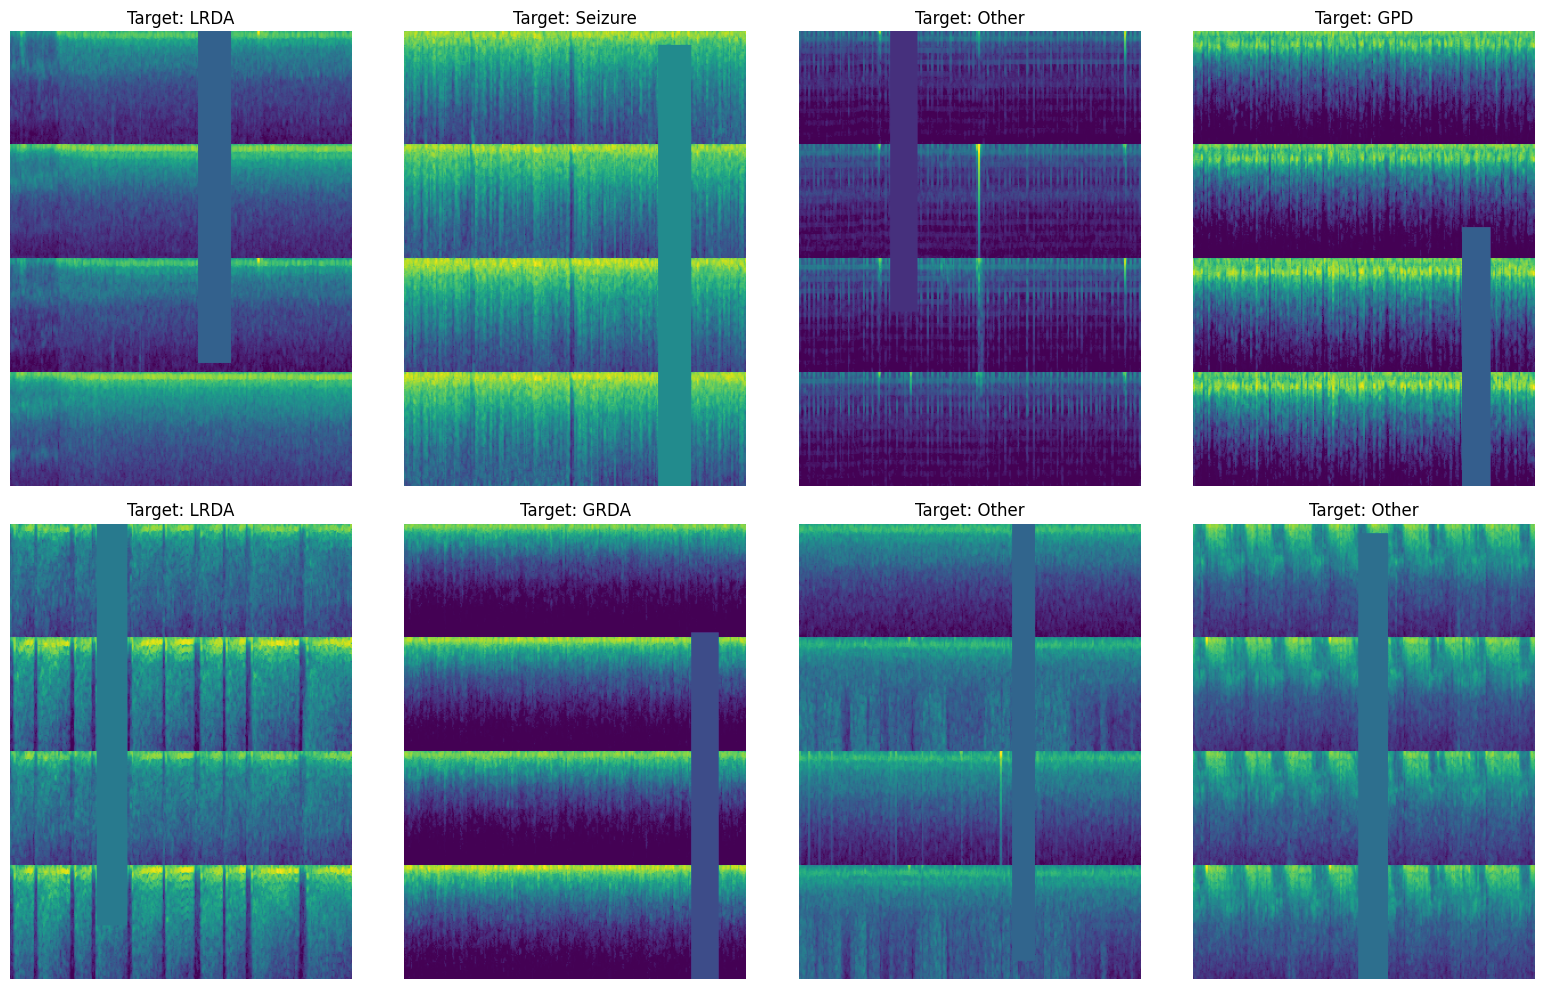

In [6]:
imgs, tars = next(iter(data_handler.train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = config.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()


del num_imgs, imgs, tars, img, tar  # For relasing RAM.

## Trainer

In [7]:
trainer = Trainer(config)

trainer.set_model()
trainer.compile_model()
trainer.show_model_summary()

Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...


Model: "image_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ res_net50v2_backbone            │ (None, None, None, 2048)  │ 23,564,800 │
│ (ResNetV2Backbone)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ avg_pool                        │ (None, 2048)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ predictions (Dense)             │ (None, 6)                 │     12,294 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 23,577,094 (89.94 MB)

 Trainable params: 23,531,654 (89.77 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [8]:
trainer.set_callbacks()
trainer.callbacks

In [9]:
trainer.train(len(data_handler.train_df), data_handler.train_ds, data_handler.valid_ds)

Epoch 1/100
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 2589s 760ms/step - loss: 1.0087 - val_loss: 1.0668 - learning_rate: 5.0000e-05
Epoch 2/100
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 2524s 756ms/step - loss: 0.5450 - val_loss: 1.4255 - learning_rate: 9.7333e-05
Epoch 3/100
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 2524s 756ms/step - loss: 0.3998 - val_loss: 1.9338 - learning_rate: 1.4467e-04
Epoch 4/100
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 2525s 757ms/step - loss: 0.3753 - val_loss: 2.7612 - learning_rate: 1.9200e-04
Epoch 5/100
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 2524s 756ms/step - loss: 0.3182 - val_loss: 1.6098 - learning_rate: 1.9196e-04
Epoch 6/100
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 2525s 757ms/step - loss: 0.2952 - val_loss: 1.3665 - learning_rate: 1.9182e-04


## Prediction

In [10]:
trainer.model.load_weights("best_model.keras")

preds = trainer.model.predict(data_handler.test_ds)

pred_df = data_handler.test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in config.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{data_handler.base_path}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.278258,0.13996,0.019572,0.094801,0.308265,0.159143
